In [1]:
%%capture
%run 00_Dataset.ipynb

In [2]:
import os
import pandas as pd
import numpy as np

In [3]:
GRB = pd.read_csv(os.path.join('../data/','GRB','GRB_data_Wang_et_al_2011.csv'))
GRB = GRB.sort_values('z', ascending=False)
zGRB = GRB['z'].to_numpy()


In [4]:
zGRB.shape

(116,)

c:\Users\Sarvesh Purohit\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:492: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  y_samples = rng.multivariate_normal(y_mean, y_cov, n_samples).T
C:\Users\Sarvesh Purohit\AppData\Local\Temp\ipykernel_13176\631166607.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


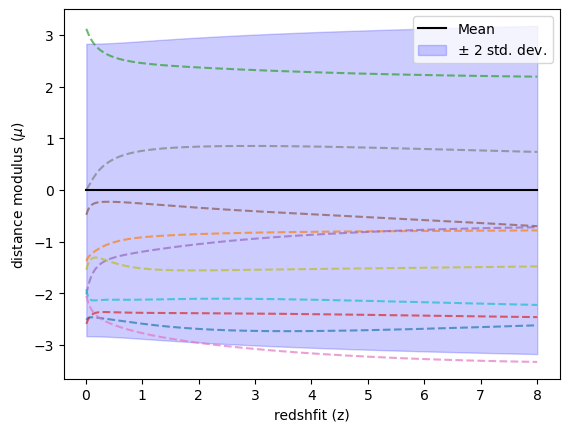

Kernel parameters before fit:
1**2 + 1**2 * DotProduct(sigma_0=1) ** 0.1 
Kernel parameters after fit: 
8.28**2 + 7.82**2 * DotProduct(sigma_0=0.0102) ** 0.1 
Log-likelihood: -270.990 
Score = 0.6833282563050915


c:\Users\Sarvesh Purohit\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:492: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  y_samples = rng.multivariate_normal(y_mean, y_cov, n_samples).T
C:\Users\Sarvesh Purohit\AppData\Local\Temp\ipykernel_13176\3638918824.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


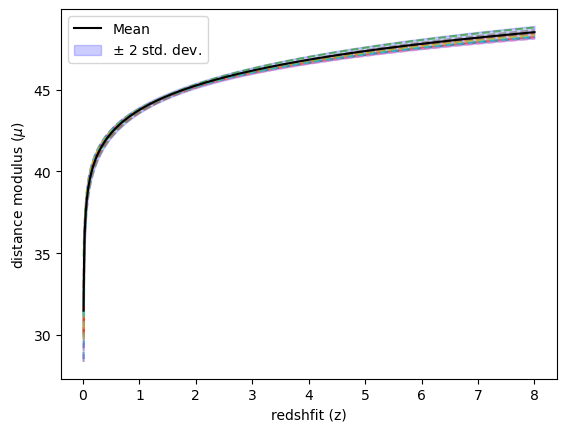

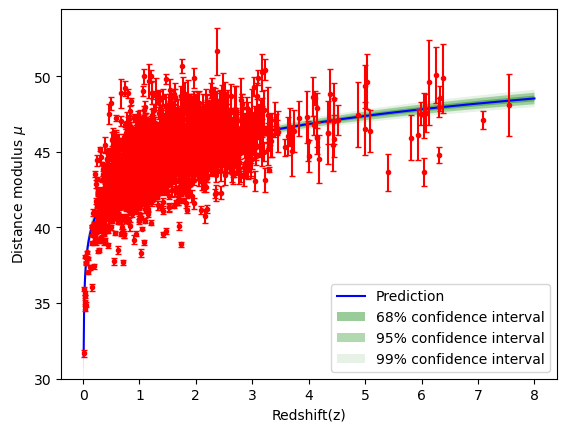

In [5]:
if modelname == 'gaussianprocess':
    
    %run 02_Model_GuassianProcess.ipynb
    
    mu, mu_err = gpr.predict(zGRB.reshape(-1,1), return_std=True)

In [6]:
if modelname == 'lstm':
    
    %run 03_Model_RNN_BNN.ipynb
    
    model_u = model_uncertainity()
    model_u.compile(
        optimizer = tf.keras.optimizers.Adam(1e-3), 
        loss = tf.keras.losses.MeanSquaredError(), 
        metrics = tf.keras.metrics.RootMeanSquaredError()
    )
    model_u.load_weights(os.path.join(out_dir,'cp.ckpt'))
    
    zGRB_reconstruct = np.expand_dims(strided_app(zGRB, 4, 1), axis=-1)
    zGRB_reconstruct = np.append(np.array([zGRB[0], zGRB[0], zGRB[0], zGRB[0]]).reshape(1,-1,1), zGRB_reconstruct, axis=0)
    zGRB_reconstruct = np.append(np.array([zGRB[0], zGRB[0], zGRB[0], zGRB[1]]).reshape(1,-1,1), zGRB_reconstruct, axis=0)
    zGRB_reconstruct = np.append(np.array([zGRB[0], zGRB[0], zGRB[1], zGRB[2]]).reshape(1,-1,1), zGRB_reconstruct, axis=0)

    mu_reconstruct_uncertainity = []
    n = 1000
    for i in range(n):
        y_pred = model_u.predict(zGRB_reconstruct, batch_size=500)[:,-1].flatten()
        y_pred = mu_scaler.inverse_transform(y_pred.reshape(-1,1)).reshape(-1)
        mu_reconstruct_uncertainity.append(y_pred)

    mu_reconstruct_uncertainity = np.array(mu_reconstruct_uncertainity)

    # save output in a file
    mu = np.mean(mu_reconstruct_uncertainity, axis=0)
    mu_err = np.std(mu_reconstruct_uncertainity, axis=0)

In [7]:
np.savetxt(os.path.join(out_dir,"reconstruction.csv"), np.array([mu, mu_err]), delimiter=",")